In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe



import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())






expanded_data = expand_data(df, "name1")
data = expanded_data['utilization']
data = data.to_frame()
data.index.name = "Datetime"
data

   location_id                  location_friendlyname location_friendlycode  \
0       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
1       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
2       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
3       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
4       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   

  location_address_cityname location_address_postnumber  \
0                     Praha                      190 00   
1                     Praha                      190 00   
2                     Praha                      190 00   
3                     Praha                      190 00   
4                     Praha                      190 00   

  location_address_streetname location_address_housenumber  \
0                  Sokolovska                       42/217   
1                  Sokolovska                 

,utilization
Datetime,
2021-01-04 00:00:00,0.0
2021-01-04 01:00:00,0.0
2021-01-04 02:00:00,0.0
2021-01-04 03:00:00,0.0
2021-01-04 04:00:00,0.0
...,...
2023-06-13 20:00:00,50.0
2023-06-13 21:00:00,50.0
2023-06-13 22:00:00,50.0


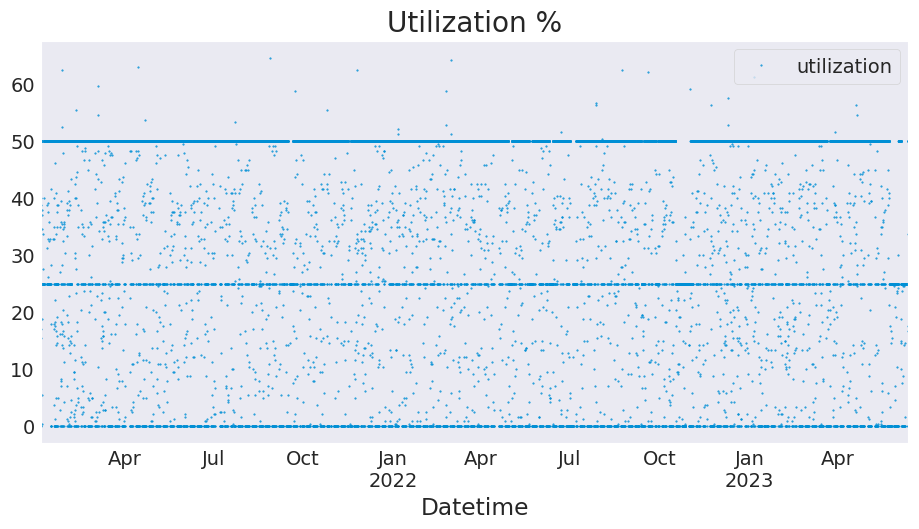

In [4]:
color_pal = sns.color_palette()
data.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Utilization %')
plt.show()

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.isocalendar().week
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='utilization')
features_and_target = pd.concat([X, y], axis=1)

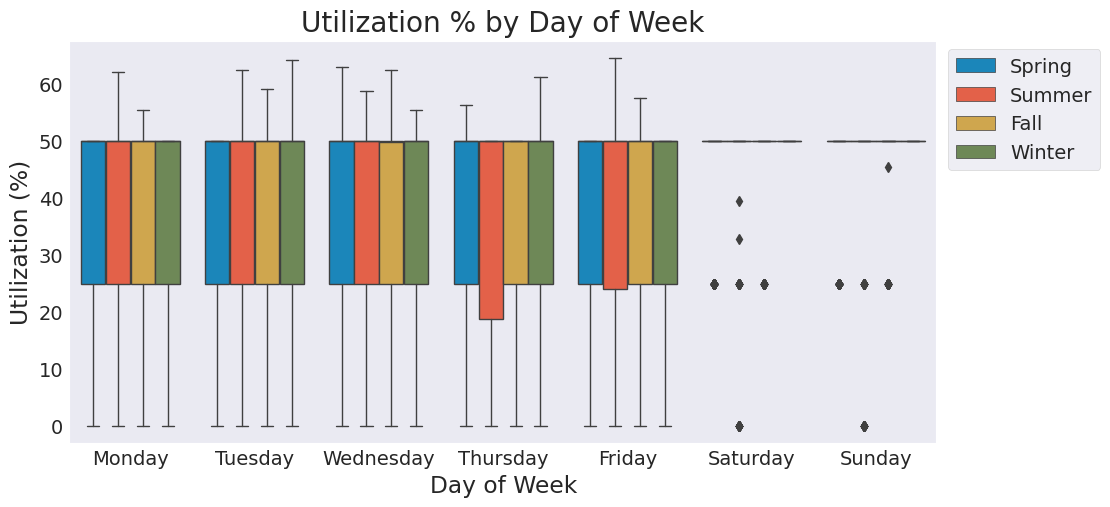

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='utilization',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Utilization % by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Utilization (%)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

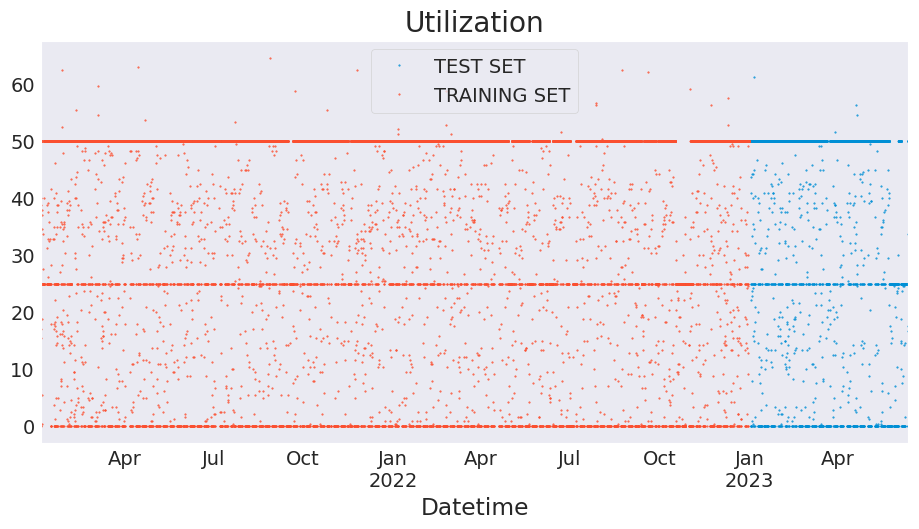

In [7]:
split_date = '1-Jan-2023'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# Plot train and test so you can see where we have split
data_test \
    .rename(columns={'utilization': 'TEST SET'}) \
    .join(data_train.rename(columns={'utilization': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Utilization', style='.', ms=1)
plt.show()

In [11]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'utilization':'y'})

In [12]:
data_train_prophet

,ds,y
0,2021-01-04 00:00:00,0.0
1,2021-01-04 01:00:00,0.0
2,2021-01-04 02:00:00,0.0
3,2021-01-04 03:00:00,0.0
4,2021-01-04 04:00:00,0.0
...,...,...
17444,2022-12-31 20:00:00,50.0
17445,2022-12-31 21:00:00,50.0
17446,2022-12-31 22:00:00,50.0
17447,2022-12-31 23:00:00,50.0


In [13]:
%%time
model = Prophet()
model.fit(data_train_prophet)

10:05:15 - cmdstanpy - INFO - Chain [1] start processing
10:05:17 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 798 ms, sys: 17.7 ms, total: 816 ms
Wall time: 2.62 s


In [15]:
# Predict on test set with model
data_test_prophet = data_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'utilization':'y'})

data_test_fcst = model.predict(data_test_prophet)

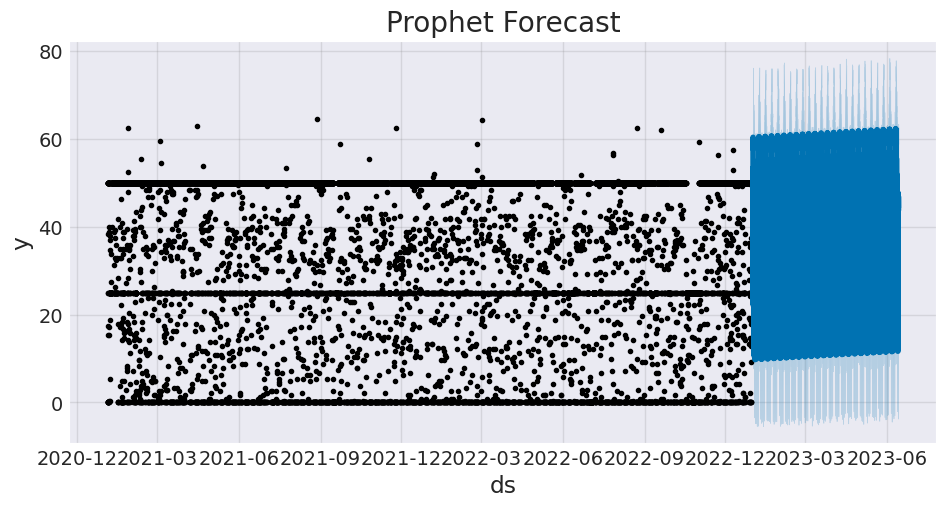

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(data_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

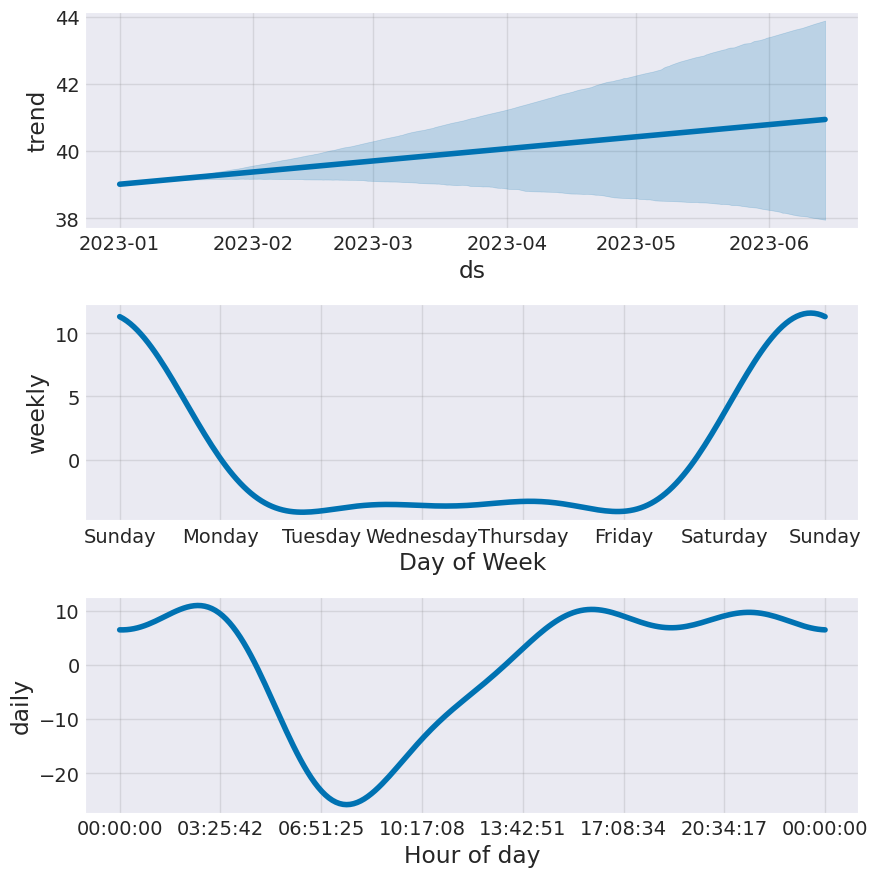

In [17]:
fig = model.plot_components(data_test_fcst)
plt.show()

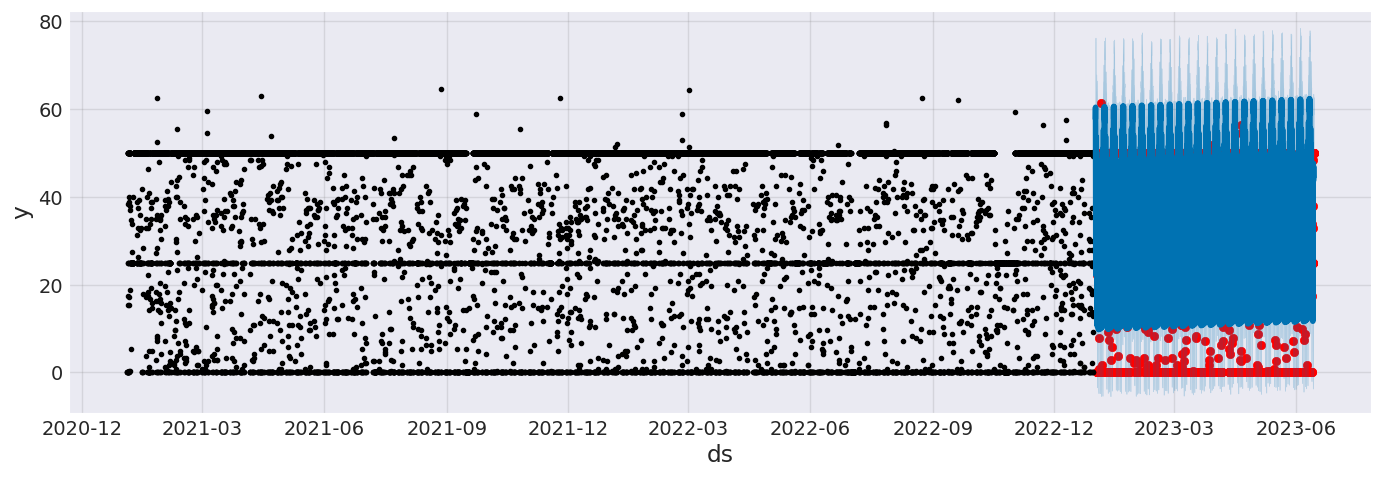

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['utilization'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

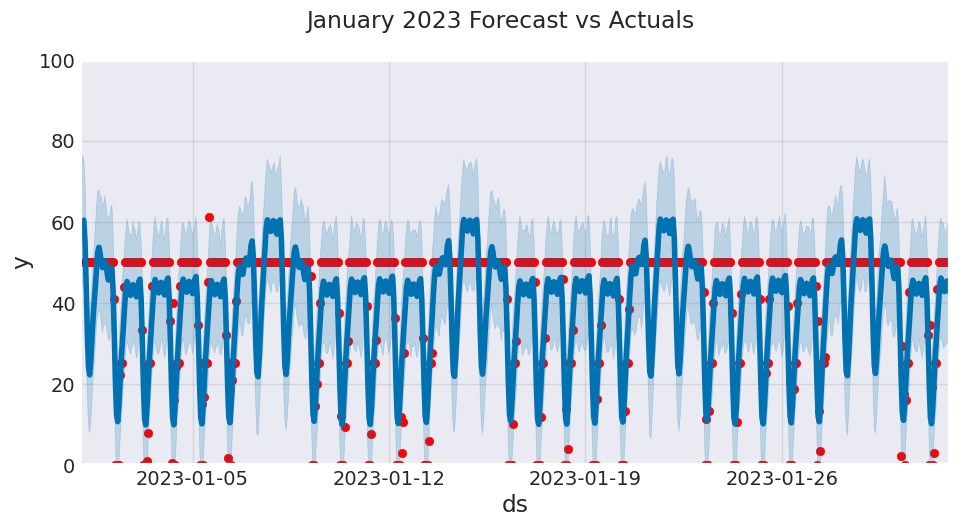

In [20]:
import datetime
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data_test.index, data_test['utilization'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
plt.xlim(datetime.date(2023, 1, 1),datetime.date(2023, 2, 1))
#plt.xticks(range(0,len(data_test_fcst.index)), data_test_fcst.index)
#ax.set_xbound(lower='01-01-2023',
#              upper='02-01-2023')
ax.set_ylim(0, 100)
plot = plt.suptitle('January 2023 Forecast vs Actuals')

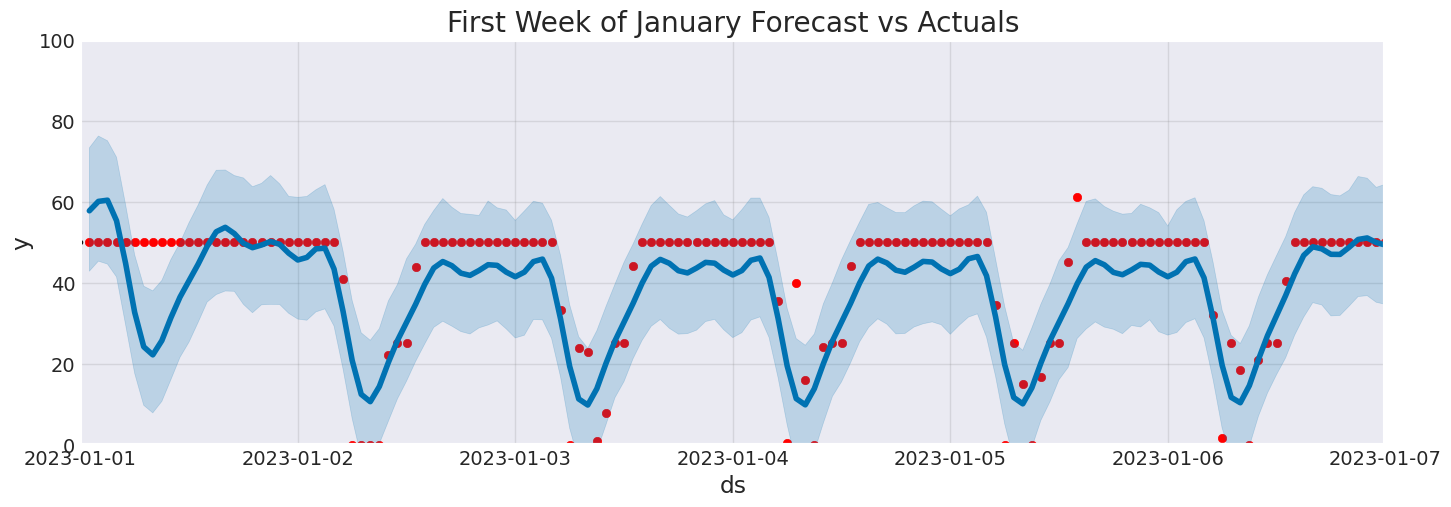

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['utilization'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(datetime.date(2023, 1, 1),datetime.date(2023, 1, 7))
ax.set_ylim(0, 100)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [22]:
np.sqrt(mean_squared_error(y_true=data_test['utilization'],
                   y_pred=data_test_fcst['yhat']))

12.241811535967253

In [23]:
mean_absolute_error(y_true=data_test['utilization'],
                   y_pred=data_test_fcst['yhat'])

9.318532225415987

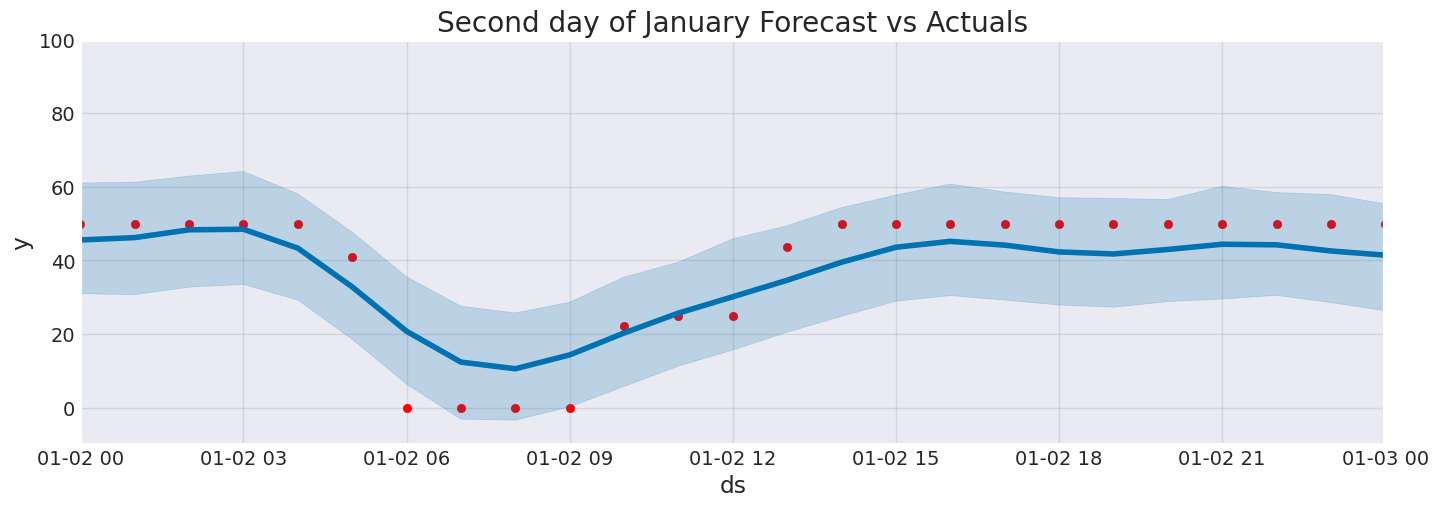

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test['utilization'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(datetime.date(2023, 1, 2),datetime.date(2023, 1, 3))
ax.set_ylim(-10, 100)
ax.set_title('Second day of January Forecast vs Actuals')
plt.show()

In [25]:
future = model.make_future_dataframe(periods=24, freq='h', include_history=False)
forecast = model.predict(future)

In [26]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01 01:00:00,39.014946,43.125418,73.127904,39.014946,39.014946,18.710771,18.710771,18.710771,7.568041,7.568041,7.568041,11.142730,11.142730,11.142730,0.0,0.0,0.0,57.725717
1,2023-01-01 02:00:00,39.015435,44.686118,75.178012,39.015435,39.015435,21.032523,21.032523,21.032523,10.120919,10.120919,10.120919,10.911605,10.911605,10.911605,0.0,0.0,0.0,60.047959
2,2023-01-01 03:00:00,39.015925,45.902510,74.030209,39.015925,39.015925,21.326911,21.326911,21.326911,10.689320,10.689320,10.689320,10.637591,10.637591,10.637591,0.0,0.0,0.0,60.342836
3,2023-01-01 04:00:00,39.016415,40.897604,70.842147,39.016415,39.016415,16.259724,16.259724,16.259724,5.937042,5.937042,5.937042,10.322682,10.322682,10.322682,0.0,0.0,0.0,55.276139
4,2023-01-01 05:00:00,39.016904,29.467300,59.292171,39.016904,39.016904,5.750577,5.750577,5.750577,-4.218572,-4.218572,-4.218572,9.969149,9.969149,9.969149,0.0,0.0,0.0,44.767482
5,2023-01-01 06:00:00,39.017394,17.610399,46.988560,39.017394,39.017394,-6.359178,-6.359178,-6.359178,-15.938702,-15.938702,-15.938702,9.579524,9.579524,9.579524,0.0,0.0,0.0,32.658216
6,2023-01-01 07:00:00,39.017883,10.533391,38.553349,39.017883,39.017883,-14.870529,-14.870529,-14.870529,-24.027099,-24.027099,-24.027099,9.156571,9.156571,9.156571,0.0,0.0,0.0,24.147355
7,2023-01-01 08:00:00,39.018373,8.016317,38.502698,39.018373,39.018373,-16.865650,-16.865650,-16.865650,-25.568911,-25.568911,-25.568911,8.703262,8.703262,8.703262,0.0,0.0,0.0,22.152723
8,2023-01-01 09:00:00,39.018862,10.441787,40.467206,39.018862,39.018862,-13.343690,-13.343690,-13.343690,-21.566438,-21.566438,-21.566438,8.222748,8.222748,8.222748,0.0,0.0,0.0,25.675173
9,2023-01-01 10:00:00,39.019352,15.867466,45.824371,39.019352,39.019352,-7.681016,-7.681016,-7.681016,-15.399347,-15.399347,-15.399347,7.718331,7.718331,7.718331,0.0,0.0,0.0,31.338336


In [34]:
########## Prophet Model Trained on all dataset ############

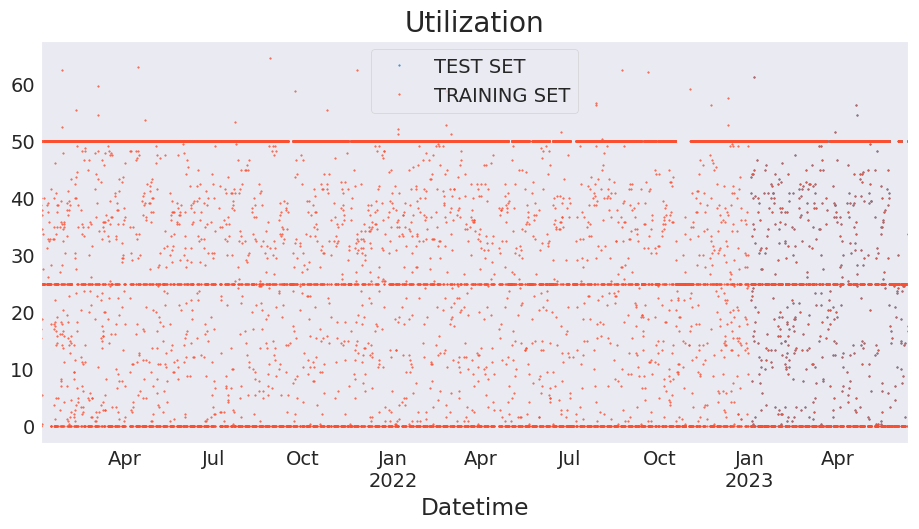

In [29]:
data_train = data.copy()


# Plot train and test so you can see where we have split
data_test \
    .rename(columns={'utilization': 'TEST SET'}) \
    .join(data_train.rename(columns={'utilization': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Utilization', style='.', ms=1)
plt.show()

In [30]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'utilization':'y'})

In [31]:
%%time
model = Prophet()
model.fit(data_train_prophet)

13:07:10 - cmdstanpy - INFO - Chain [1] start processing
13:07:12 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.77 s, sys: 45.1 ms, total: 1.81 s
Wall time: 4.13 s


In [32]:
future = model.make_future_dataframe(periods=24, freq='h', include_history=False)
forecast = model.predict(future)

In [33]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-06-14 01:00:00,35.813390,23.237000,51.720305,35.813390,35.813390,1.309637,1.309637,1.309637,7.564762,...,-3.774746,-3.774746,-3.774746,-2.480379,-2.480379,-2.480379,0.0,0.0,0.0,37.123027
1,2023-06-14 02:00:00,35.812667,25.968612,53.932196,35.812667,35.812667,3.816271,3.816271,3.816271,10.074366,...,-3.784481,-3.784481,-3.784481,-2.473613,-2.473613,-2.473613,0.0,0.0,0.0,39.628938
2,2023-06-14 03:00:00,35.811944,26.272149,56.169439,35.811944,35.811944,4.338389,4.338389,4.338389,10.597370,...,-3.792063,-3.792063,-3.792063,-2.466918,-2.466918,-2.466918,0.0,0.0,0.0,40.150333
3,2023-06-14 04:00:00,35.811221,21.129912,49.458615,35.811221,35.811221,-0.385777,-0.385777,-0.385777,5.871692,...,-3.797177,-3.797177,-3.797177,-2.460292,-2.460292,-2.460292,0.0,0.0,0.0,35.425444
4,2023-06-14 05:00:00,35.810498,10.869022,39.639658,35.810498,35.810498,-10.411746,-10.411746,-10.411746,-4.158426,...,-3.799584,-3.799584,-3.799584,-2.453736,-2.453736,-2.453736,0.0,0.0,0.0,25.398752
5,2023-06-14 06:00:00,35.809775,-0.682160,27.733813,35.809775,35.809775,-21.960885,-21.960885,-21.960885,-15.714514,...,-3.799120,-3.799120,-3.799120,-2.447252,-2.447252,-2.447252,0.0,0.0,0.0,13.848890
6,2023-06-14 07:00:00,35.809052,-8.221521,21.210225,35.809052,35.809052,-29.945626,-29.945626,-29.945626,-23.709078,...,-3.795710,-3.795710,-3.795710,-2.440838,-2.440838,-2.440838,0.0,0.0,0.0,5.863427
7,2023-06-14 08:00:00,35.808330,-10.139888,19.482396,35.808330,35.808330,-31.519942,-31.519942,-31.519942,-25.296083,...,-3.789362,-3.789362,-3.789362,-2.434496,-2.434496,-2.434496,0.0,0.0,0.0,4.288388
8,2023-06-14 09:00:00,35.807607,-5.366817,21.056862,35.807607,35.807607,-27.656086,-27.656086,-27.656086,-21.447683,...,-3.780177,-3.780177,-3.780177,-2.428226,-2.428226,-2.428226,0.0,0.0,0.0,8.151521
9,2023-06-14 10:00:00,35.806884,-0.404395,28.432108,35.806884,35.806884,-21.629523,-21.629523,-21.629523,-15.439155,...,-3.768340,-3.768340,-3.768340,-2.422028,-2.422028,-2.422028,0.0,0.0,0.0,14.177361
